# WASP-39b NIRISS ExoIris analysis

**Author:** Hannu Parviainen </br>
**Edited:** 2025-08-08 </br>
**ExoIris version:** 0.19 

This notebook carries out an ExoIris transmission spectroscopy analysis for the JWST NIRISS SOSS observations of WASP-39b reduced by [Carter et al. (2024)](https://www.nature.com/articles/s41550-024-02292-x). The original reduction and analysis of the observations was presented in [Feinstein et al. (2023)](https://www.nature.com/articles/s41586-022-05674-1).

**Note:** This notebook assumes you have already read the basic [ExoIris tutorials](https://exoiris.readthedocs.io/en/latest/examples/index.html).

In [18]:
%run ../setup_multiprocessing.py

In [19]:
from multiprocessing import Pool

import numpy as np
import xarray as xa

from matplotlib.pyplot import subplots, setp, rc
from exoiris import ExoIris, TSData

rc('figure', figsize=(14, 4))

In [20]:
%run core.py

## Read the data

In [21]:
d1 = read_data('data/ZENODO/1_TIME_SERIES_SPECTRA/NIRISS_SOSS_Order1_Spectra.h5', 'WASP-39b-NIRISS-O1', ephemeris=eph, ngroup=1)
d2 = read_data('data/ZENODO/1_TIME_SERIES_SPECTRA/NIRISS_SOSS_Order2_Spectra.h5', 'WASP-39b-NIRISS-O2', ephemeris=eph, ngroup=0)

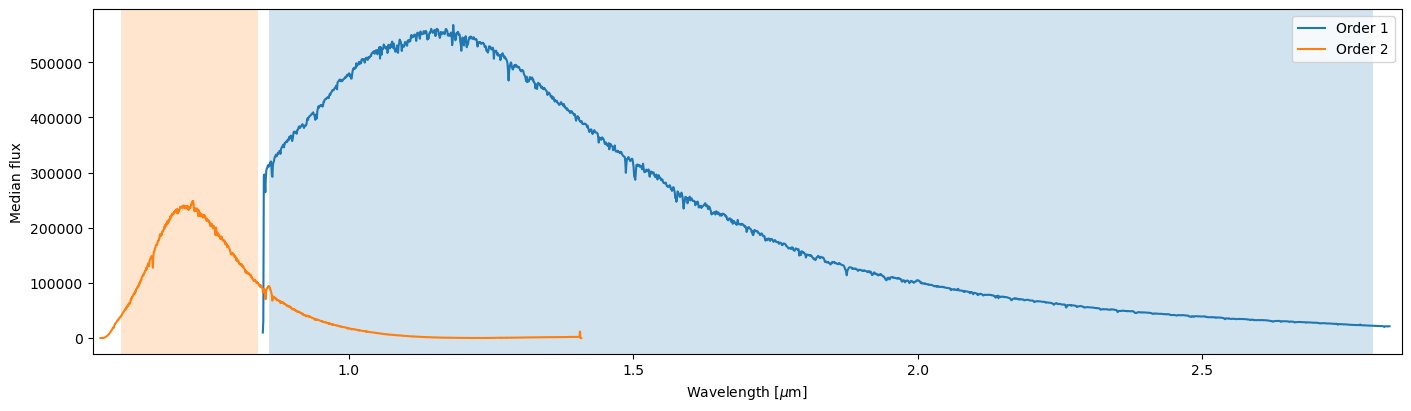

In [22]:
fig, ax = subplots(constrained_layout=True)
ax.plot(d1.wavelength, np.nanmedian(d1.fluxes, 1), c='C00', label='Order 1')
ax.plot(d2.wavelength, np.nanmedian(d2.fluxes, 1), c='C01', label='Order 2')
ax.axvspan(0.86, 2.8, zorder=-1, alpha=0.2, fc='C00')
ax.axvspan(0.6, 0.84, zorder=-1, alpha=0.2, fc='C01')
ax.legend()
setp(ax, xlabel='Wavelength [$\mu$m]', ylabel='Median flux', xlim=(0.55, 2.85));

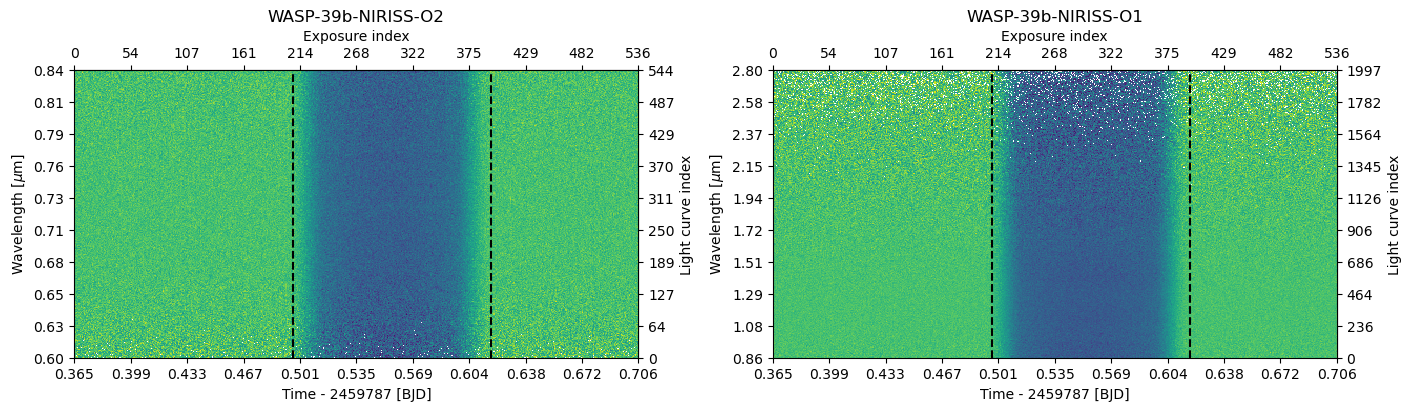

In [23]:
d1.crop_wavelength(0.86, 2.8)
d1.normalize_to_poly()
d1.mask_outliers()

d2.crop_wavelength(0.6, 0.84)
d2.normalize_to_poly()
d2.mask_outliers()

fig, axs = subplots(1, 2, constrained_layout=True)
d2.plot(ax=axs[0])
d1.plot(ax=axs[1]);

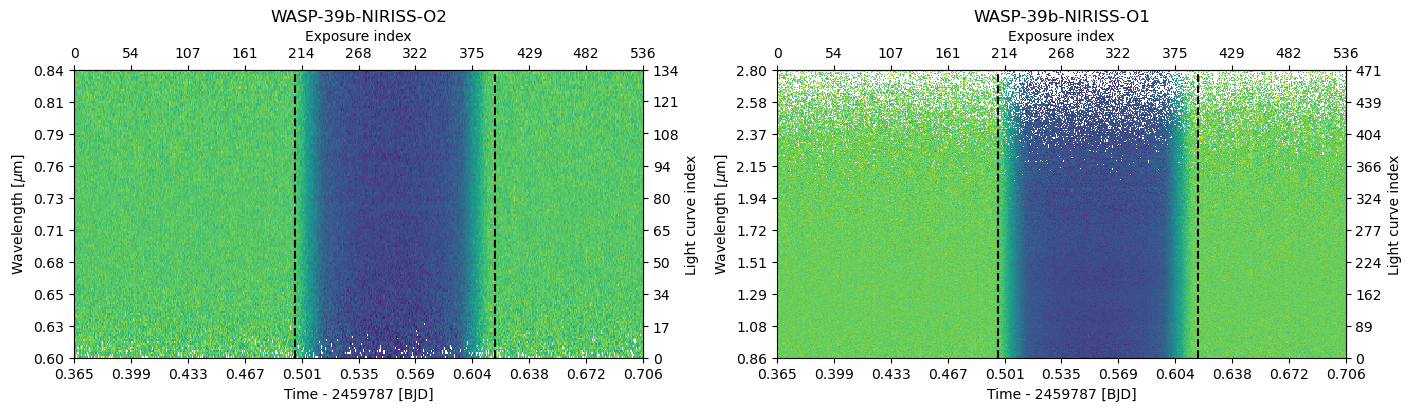

In [24]:
db = d2.bin_wavelength(r=400, estimate_errors=True) + d1.bin_wavelength(r=400, estimate_errors=True)

fig, axs = subplots(1, 2, constrained_layout=True)
db.plot(axs=axs);

Estimate the average uncertainties for each spectrophotometric light curve based on the out-of-transit data.

In [25]:
[d.estimate_average_uncertainties() for d in db];

## Initialise the analysis

In [26]:
ts = ExoIris('WASP-39b-NIRISS-wn', 'power-2', db, nk=100, interpolation='makima')

In [27]:
ts.set_prior('tc_00', 'NP', eph.transit_center(db[0].time.mean()), 0.003)  # Zero epoch for epoch group 0
ts.set_prior('p', 'NP', eph.period, 1e-5)                                  # Orbital period
ts.set_prior('sigma_m_00', 'UP', 0.8, 2.0)                                 # Uncertainty multiplier for noise group 0
ts.set_prior('sigma_m_01', 'UP', 0.8, 2.0)                                 # Uncertainty multiplier for noise group 1
ts.set_prior('bl_00_c', 'NP', 1.0, 0.001)                                  # Baseline constant for data set 0
ts.set_prior('bl_01_c', 'NP', 1.0, 0.001)                                  # Baseline constant for data set 1
ts.set_radius_ratio_prior('UP', 0.14, 0.15)                             
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=10)

We use linearly spaced radius ratio knots for the whole wavelength range by default. Let's add also some detail around the K line near 768 nm. We can do this by calling `ExoIris.add_radius_ratio_knots`, but let's first also remove any existing knots inside detailed wavelength region.

In [28]:
knots = ts.k_knots.copy()
knots_k = np.linspace(0.768 - 0.02, 0.768 + 0.02, 7)
ts.set_radius_ratio_knots(knots[~((knots > knots_k[0]) & (knots < knots_k[-1]))])
ts.add_radius_ratio_knots(knots_k)

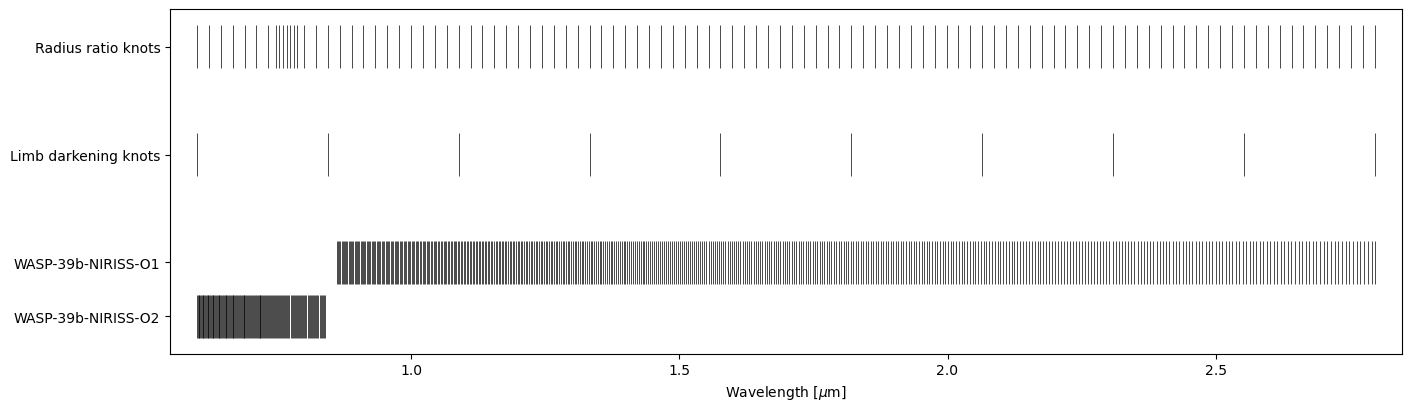

In [29]:
ts.plot_setup();

## Fit the white light curve

In [30]:
ts.fit_white()

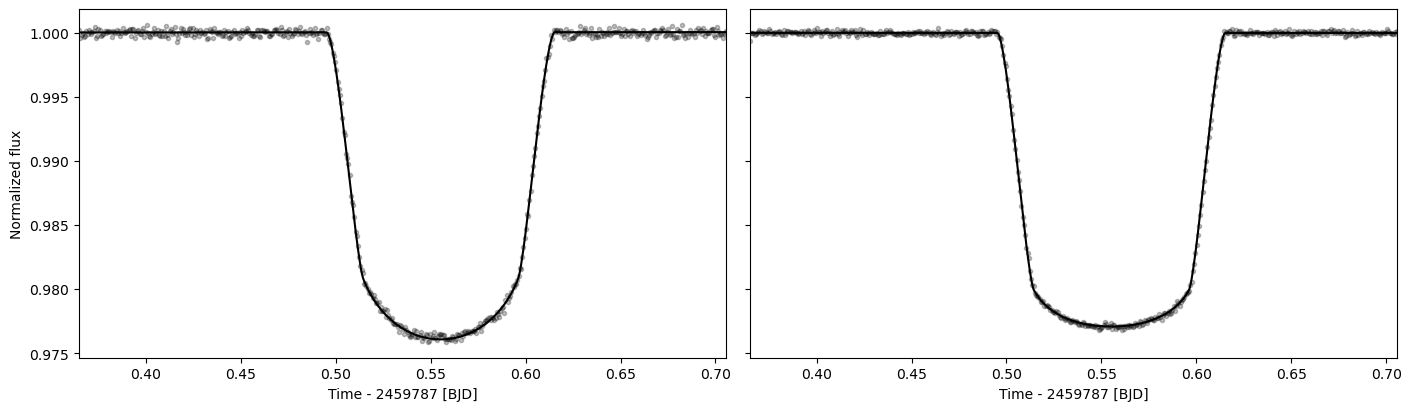

In [31]:
ts.plot_white(ncols=2, figsize=(14, 4));

In [32]:
ts.save(overwrite=True)

## Fit the transmission spectroscopy

In [33]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/2500 [00:00<?, ?it/s]

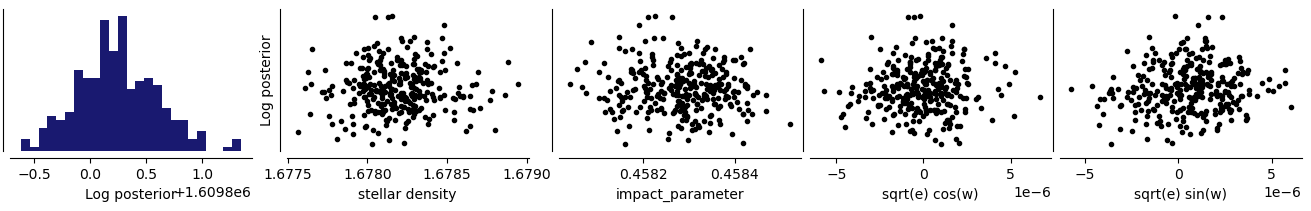

In [34]:
ts.fit(niter=2500, npop=300, pool=pool, lnpost=lnpostf)

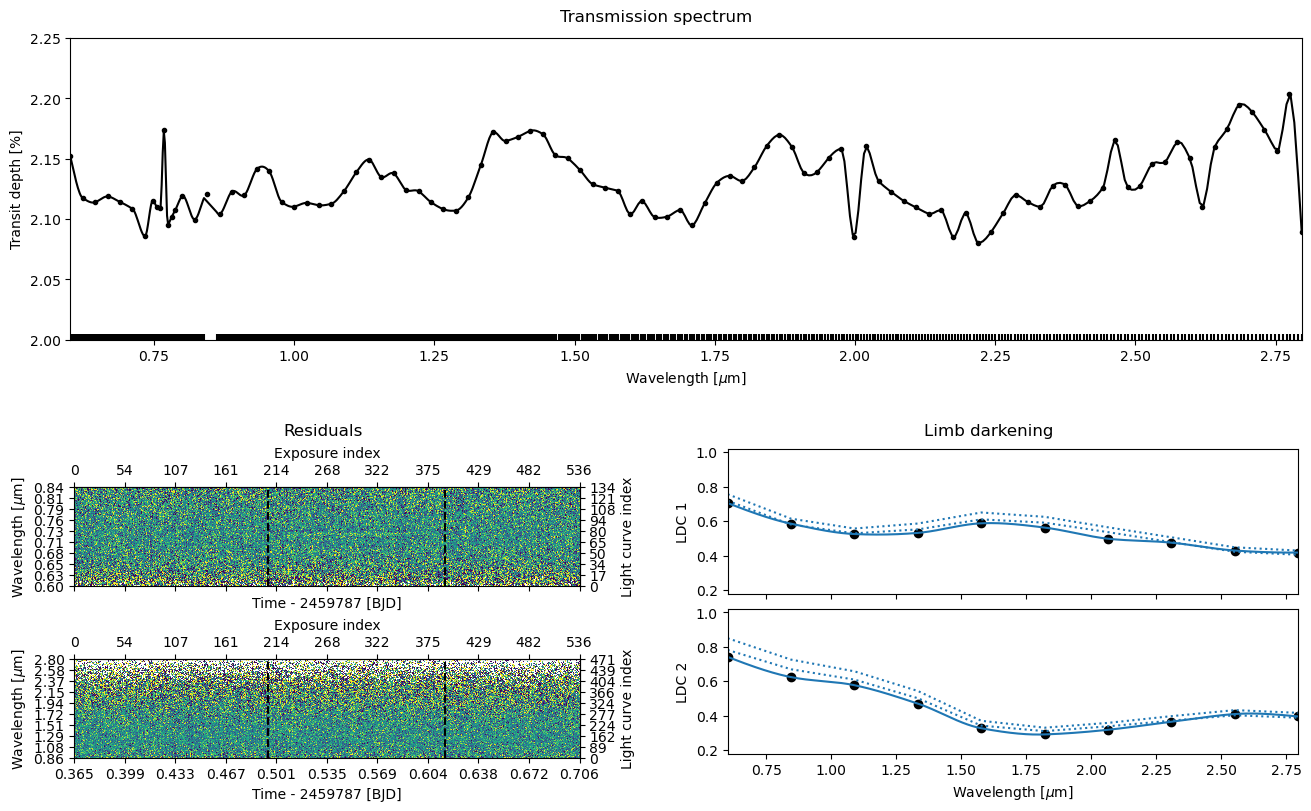

In [35]:
ts.plot_fit(result='fit', figsize=(13, 8), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='linear', ylim=(2.0, 2.25)));

In [36]:
ts.save(overwrite=True)

## Sample the posterior

In [37]:
ts.sample(1000, thin=100, repeats=6, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 4/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 5/6:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 6/6:   0%|          | 0/1000 [00:00<?, ?it/s]

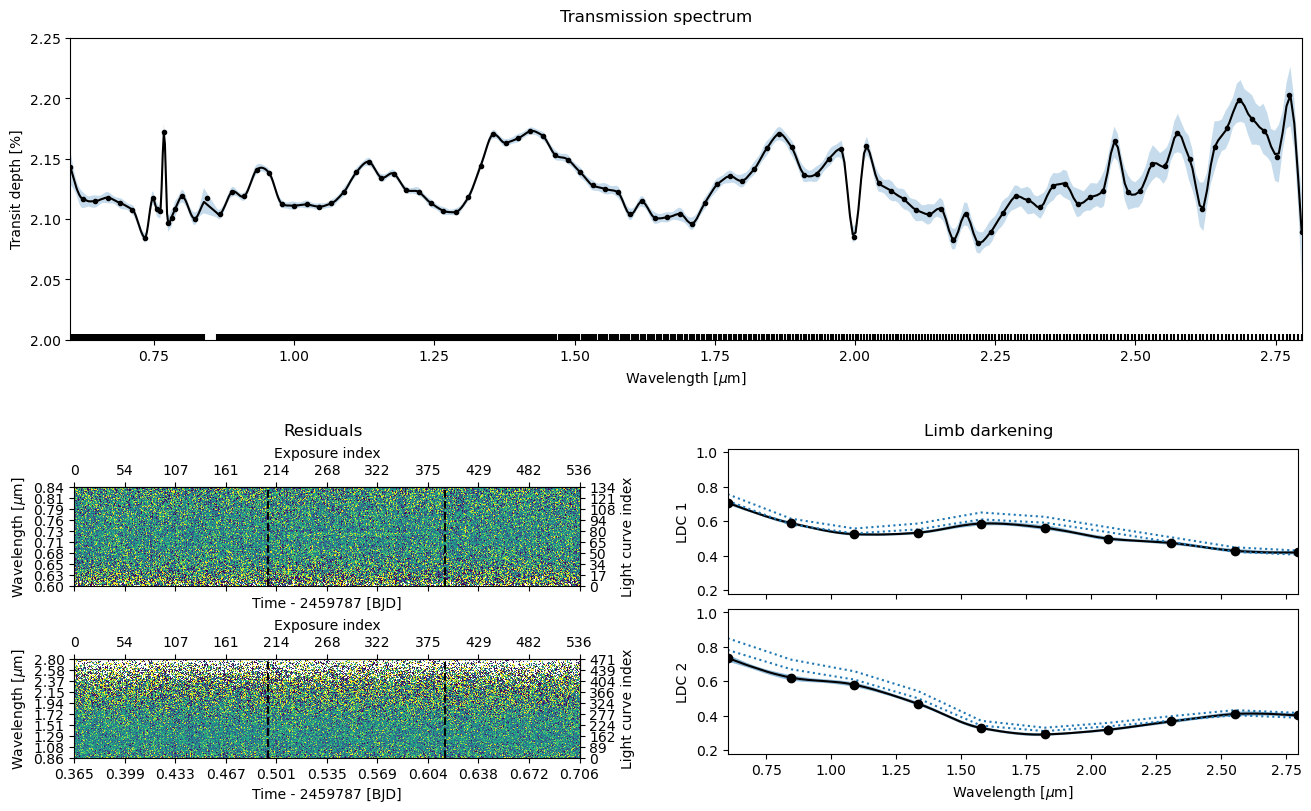

In [38]:
ts.plot_fit(result='mcmc', figsize=(13, 8), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='linear', ylim=(2.0, 2.25)));

In [39]:
ts.save()

In [40]:
pool.close()

---

<center>&copy;2025 Hannu Parviainen</center>